In [1]:
import numpy as np
import pandas as pd
import unicodecsv
import re
from scipy import sparse
from random import shuffle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn import metrics, preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC


from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display


In [2]:
reviewData = []   
file_path = 'ReviewScraped1.csv'
review_scraped_data = pd.read_csv(file_path)
review_scraped_data.shape

(4102, 2)

In [3]:
scraped_data = review_scraped_data.sample(frac = 1)
scraped_data.head()

,text,star
2078,Good food but very cramped insideFood here was...,4
812,"Interesting, delicious foodDear Ellewell66,\n\...",5
1176,My new favourite vegan pizzaThe food is so goo...,4
3145,Awful experience - won't be going back.Great e...,2
2134,"Last minute bookingHi MotovatoHamshire_UK,\n\n...",4


In [4]:
train = scraped_data[0:1272]
test = scraped_data[1272:]

In [5]:
''' Source, test and train dataframe are transformed based to star value to analyse data in better way '''

train_transform_dummies = pd.get_dummies(train, columns = ['star'])
test_transform_dummies = pd.get_dummies(test, columns = ['star'])
complete_data = pd.get_dummies(scraped_data , columns = ['star'])

In [6]:
complete_data.head()

,text,star_1,star_2,star_3,star_4,star_5
2078,Good food but very cramped insideFood here was...,0,0,0,1,0
812,"Interesting, delicious foodDear Ellewell66,\n\...",0,0,0,0,1
1176,My new favourite vegan pizzaThe food is so goo...,0,0,0,1,0
3145,Awful experience - won't be going back.Great e...,0,1,0,0,0
2134,"Last minute bookingHi MotovatoHamshire_UK,\n\n...",0,0,0,1,0


In [7]:
train_transform_dummies.head()

,text,star_1,star_2,star_3,star_4,star_5
2078,Good food but very cramped insideFood here was...,0,0,0,1,0
812,"Interesting, delicious foodDear Ellewell66,\n\...",0,0,0,0,1
1176,My new favourite vegan pizzaThe food is so goo...,0,0,0,1,0
3145,Awful experience - won't be going back.Great e...,0,1,0,0,0
2134,"Last minute bookingHi MotovatoHamshire_UK,\n\n...",0,0,0,1,0


In [8]:
test_transform_dummies.head()

,text,star_1,star_2,star_3,star_4,star_5
1201,Nepal meets Shehperd's BushFreshly prepared Ne...,0,0,0,1,0
3210,Never Again!We are really sorry to hear this. ...,1,0,0,0,0
3261,Don't Trust Your Reservation ConfirmationDear ...,1,0,0,0,0
3902,Just greatWell...I liked it a lot. Very good f...,0,0,0,0,1
825,DinnerFresh and tasty food. We had three diffe...,0,0,0,0,1


In [9]:
''' 
    SPLITING ORIGINAL DATAFRAME INTO SMALL DATASET ACCORDING TO STAR VALUES 
    THIS HELPS TO PLOT STAR EASILY 
'''
star1 = train_transform_dummies.loc[train_transform_dummies.star_1 == 1]
star2 = train_transform_dummies.loc[train_transform_dummies.star_2 == 1]
star3 = train_transform_dummies.loc[train_transform_dummies.star_3 == 1]
star4 = train_transform_dummies.loc[train_transform_dummies.star_4 == 1]
star5 = train_transform_dummies.loc[train_transform_dummies.star_5 == 1]

In [10]:
''' 
    WORDCLOD PLOTING FUNTION DEFINATION  
'''

def wordcloud(tweets,col,col2):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="black",stopwords=stopwords).generate(" ".join([i for i in tweets[col]]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("{}".format(col2))

In [11]:
star1.head()

,text,star_1,star_2,star_3,star_4,star_5
166,Don't botherI've been to Del'Aziz twice before...,1,0,0,0,0
1783,Pizza is amazing but staff is terrible not wor...,1,0,0,0,0
1753,Yesterdays' starThis was a trailblazer that st...,1,0,0,0,0
3100,The only good thing was the serviceThe breakfa...,1,0,0,0,0
2724,Disappointingthank you for telling me that our...,1,0,0,0,0


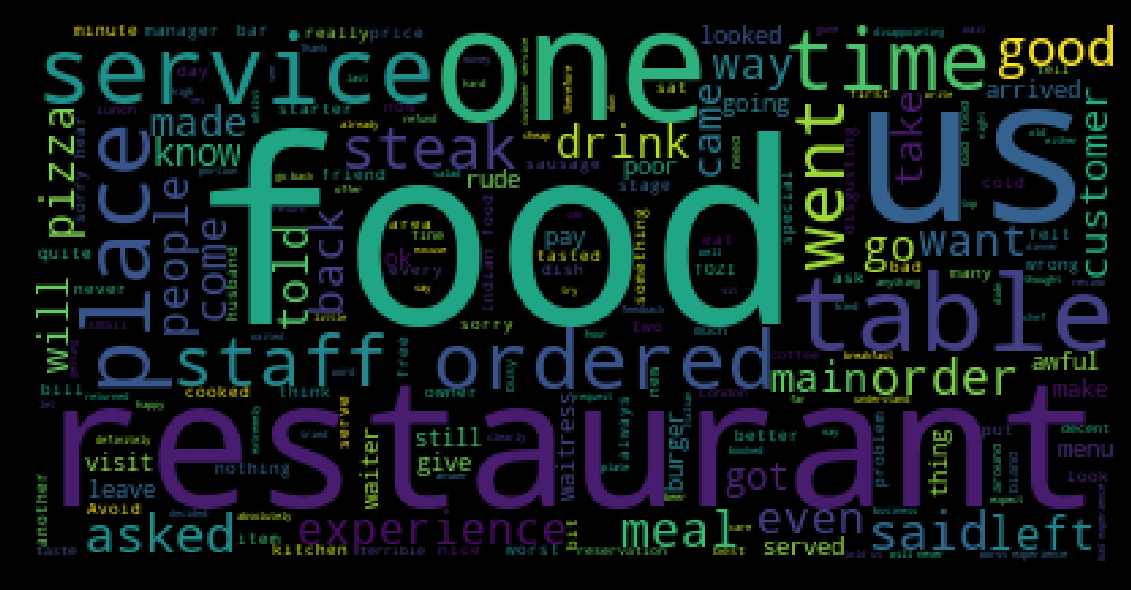

In [12]:
wordcloud(star1,'text','star-1')  

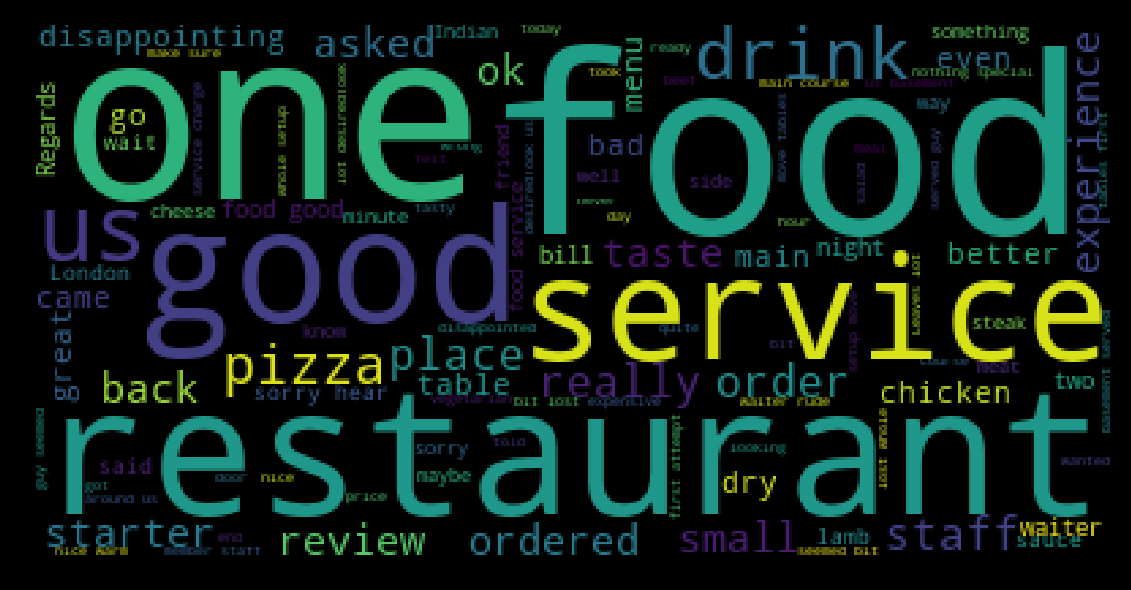

In [13]:
wordcloud(star2,'text','star-2')  

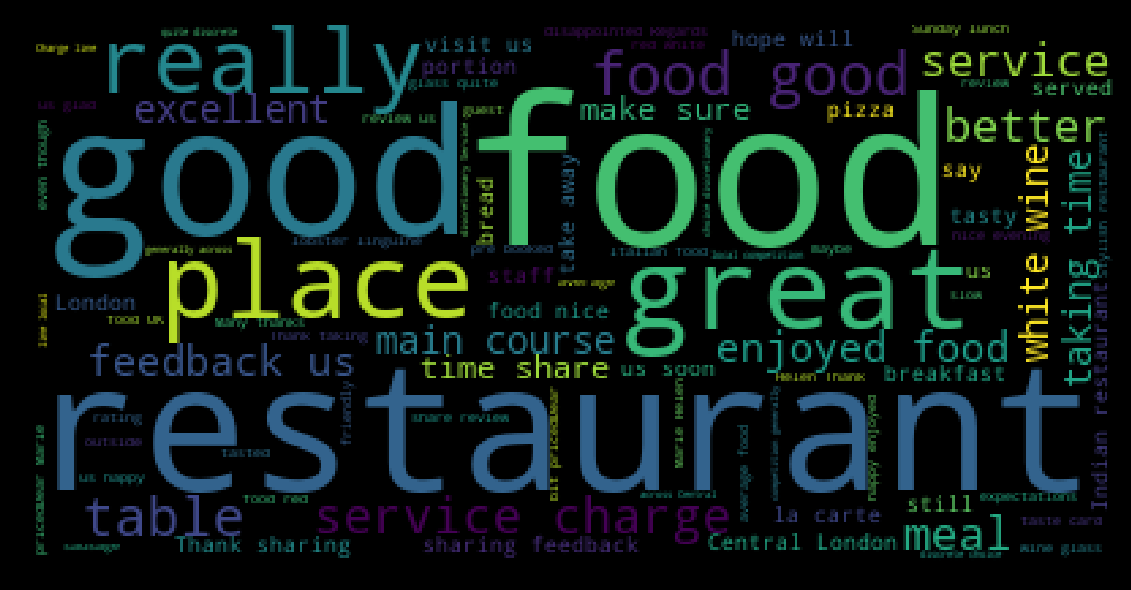

In [14]:
wordcloud(star3,'text','star-3')  

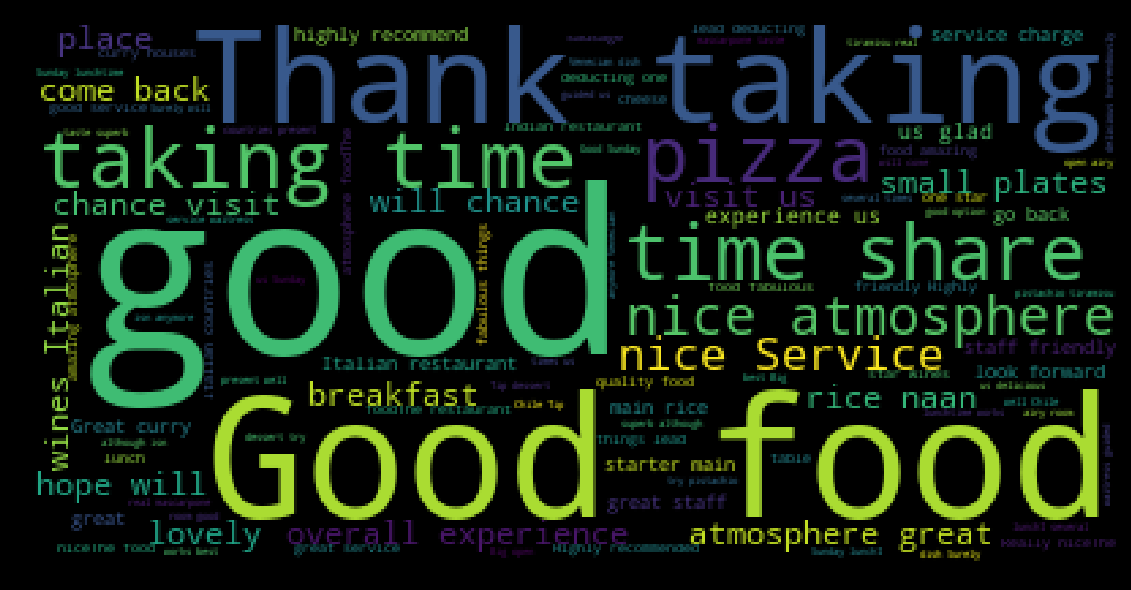

In [15]:
wordcloud(star4,'text','star-4')  

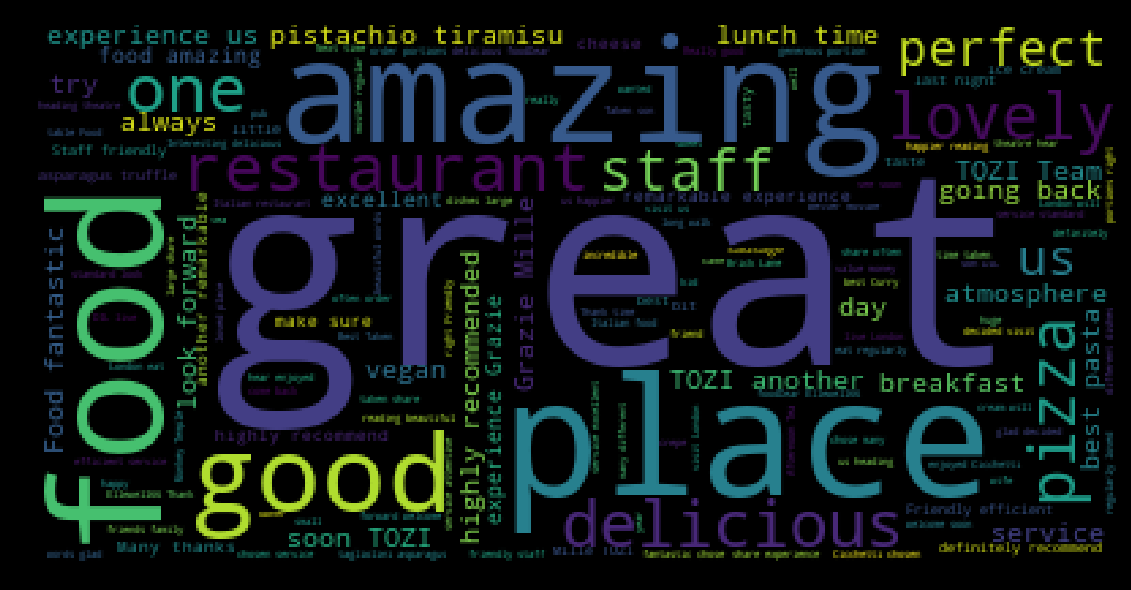

In [16]:
wordcloud(star5,'text','star-5')  

In [17]:
tweets = complete_data

''' Analyisis performance with VADER '''

from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

C:\Users\naveen\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [18]:
''' 
    remove lemmatizer funtionality was insipred from 
    https://datascienceplus.com/twitter-analysis-with-python/ 
    and moddifed based on our requirment conditions 
'''


tweets['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in tweets['text']]       

tfidf = TfidfVectorizer(min_df=10,use_idf=True)
X = tfidf.fit_transform(tweets['text_lem'].str.upper())

sid = SentimentIntensityAnalyzer()

tweets['sentiment_compound_polarity']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['compound'])
tweets['sentiment_neutral']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['neu'])
tweets['sentiment_negative']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['neg'])
tweets['sentiment_pos']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['pos'])

tweets['sentiment_type']=''

tweets.loc[tweets.sentiment_compound_polarity>0.60,'sentiment_type']='EXCELLENT_REVIWES'
tweets.loc[(tweets.sentiment_compound_polarity> 0.2)& (tweets.sentiment_compound_polarity< 0.6),'sentiment_type']='GOOD_REVIEWS'
tweets.loc[(tweets.sentiment_compound_polarity> -0.2) & (tweets.sentiment_compound_polarity< 0.2),'sentiment_type']='NEUTRAL_REVIEWS'
tweets.loc[(tweets.sentiment_compound_polarity> -0.6) & (tweets.sentiment_compound_polarity< -0.2),'sentiment_type']='POOR_REVIEWS'
tweets.loc[(tweets.sentiment_compound_polarity> -1) & (tweets.sentiment_compound_polarity< -0.6),'sentiment_type']='WORST_REVIEWS'

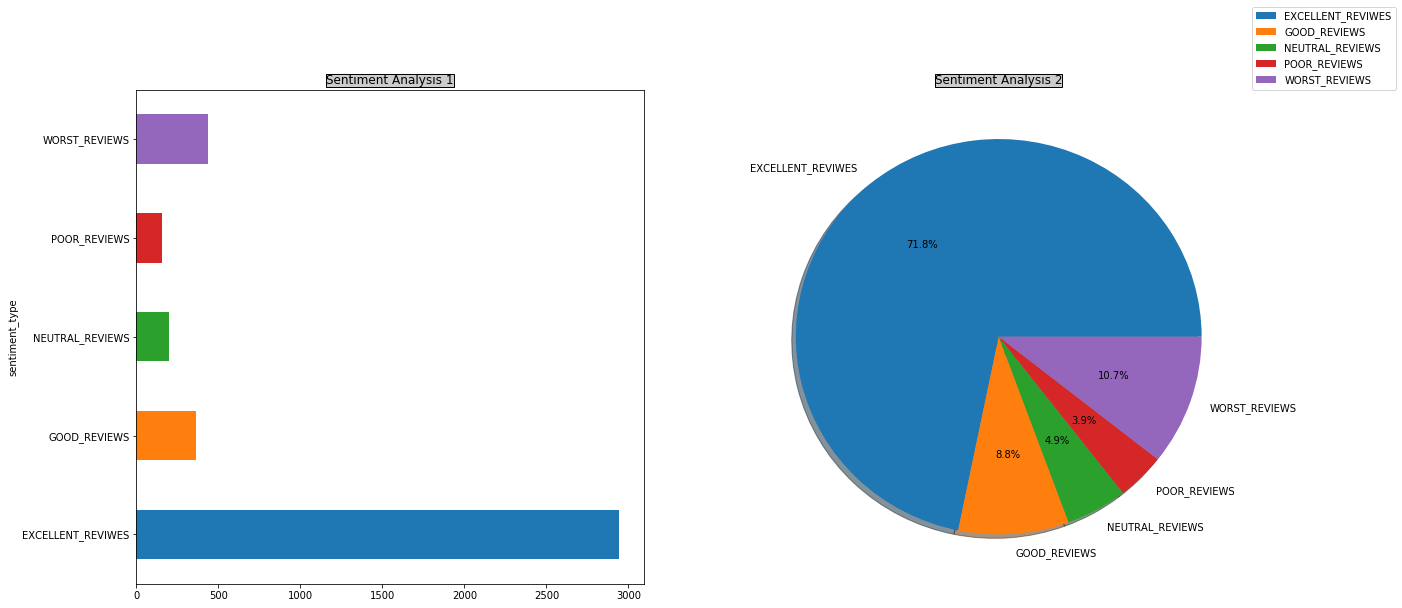

In [19]:
tweets_sentiment = tweets.groupby(['sentiment_type'])['sentiment_compound_polarity'].count()
tweets_sentiment.rename("",inplace=True)
plt.subplot(221)
tweets_sentiment.transpose().plot(kind='barh',figsize=(20, 20))
plt.title('Sentiment Analysis 1', bbox={'facecolor':'0.8', 'pad':0})
plt.subplot(222)
tweets_sentiment.plot(kind='pie',figsize=(20, 20),autopct='%1.1f%%',shadow=True)
plt.legend(bbox_to_anchor=(1, 1), loc=3, borderaxespad=0.)
plt.title('Sentiment Analysis 2', bbox={'facecolor':'0.8', 'pad':0})
plt.show()

In [31]:
'''Vader process result'''

tweets.loc[tweets.sentiment_type =='EXCELLENT_REVIWES', 'vader_label'] = 5
tweets.loc[tweets.sentiment_type =='GOOD_REVIEWS', 'vader_label'] = 4
tweets.loc[tweets.sentiment_type =='NEUTRAL_REVIEWS', 'vader_label'] = 3
tweets.loc[tweets.sentiment_type =='POOR_REVIEWS', 'vader_label'] = 2
tweets.loc[tweets.sentiment_type =='WORST_REVIEWS', 'vader_label'] = 1

vander_df = tweets[['text','vader_label']]


In [25]:
vander_df = pd.get_dummies(vander_df, columns = ['vader_label'])
vander_df.head()

,text,vader_label_1,vader_label_2,vader_label_3,vader_label_4,vader_label_5
2078,Good food but very cramped insideFood here was...,0,0,0,0,1
812,"Interesting, delicious foodDear Ellewell66,\n\...",0,0,0,0,1
1176,My new favourite vegan pizzaThe food is so goo...,0,0,0,1,0
3145,Awful experience - won't be going back.Great e...,0,0,0,0,1
2134,"Last minute bookingHi MotovatoHamshire_UK,\n\n...",0,0,0,0,1


In [26]:
from sklearn.metrics import accuracy_score
class_names = ['star_1','star_2','star_3','star_4','star_5']
vader_labels = ['vader_label_1','vader_label_2','vader_label_3','vader_label_4','vader_label_5']
vander_accuracy_score = []
for i, class_name in enumerate(class_names):
    vader_label = vader_labels[i]
    temp = accuracy_score(vander_df[vader_label],complete_data[class_name])
    vander_accuracy_score.append(temp)
print(vander_accuracy_score)

t = metrics.classification_report(np.argmax(complete_data[class_names].values, axis = 1),np.argmax(vander_df[vader_labels].values, axis = 1))
print(t)

[0.8295953193564115, 0.8612871769868357, 0.8074110190151146, 0.7013651877133106, 0.51511457825451]
             precision    recall  f1-score   support

          0       0.70      0.35      0.47       872
          1       0.28      0.09      0.13       499
          2       0.22      0.06      0.10       677
          3       0.30      0.10      0.15      1082
          4       0.33      0.99      0.49       972

avg / total       0.38      0.36      0.29      4102



In [27]:
complete_data.loc[complete_data.star_5 == 1,'review_name']='EXCELLENT_REVIWES'
complete_data.loc[complete_data.star_4 == 1,'review_name']='GOOD_REVIEWS'
complete_data.loc[complete_data.star_3 == 1,'review_name']='NEUTRAL_REVIEWS'
complete_data.loc[complete_data.star_2 == 1,'review_name']='POOR_REVIEWS'
complete_data.loc[complete_data.star_1 == 1,'review_name']='WORST_REVIEWS'

Text(0.5,1,'')

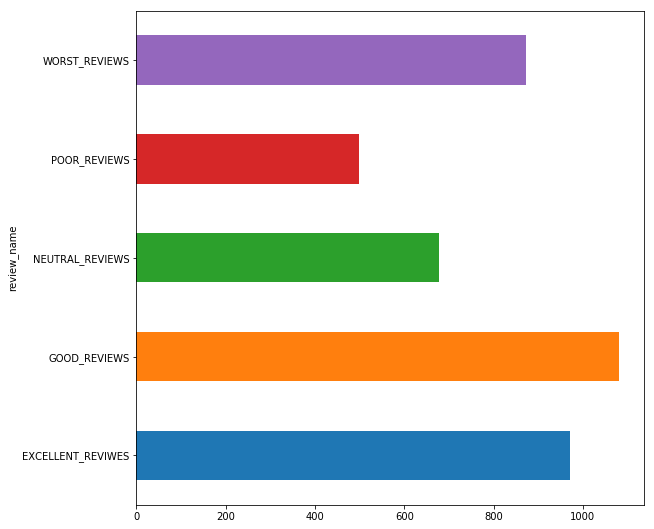

In [28]:
scraped_sentiment = complete_data.groupby(['review_name'])['text'].count()
plt.subplot(221)
scraped_sentiment.transpose().plot(kind='barh',figsize=(20, 20))
plt.title('', bbox={'facecolor':'0.8', 'pad':0})


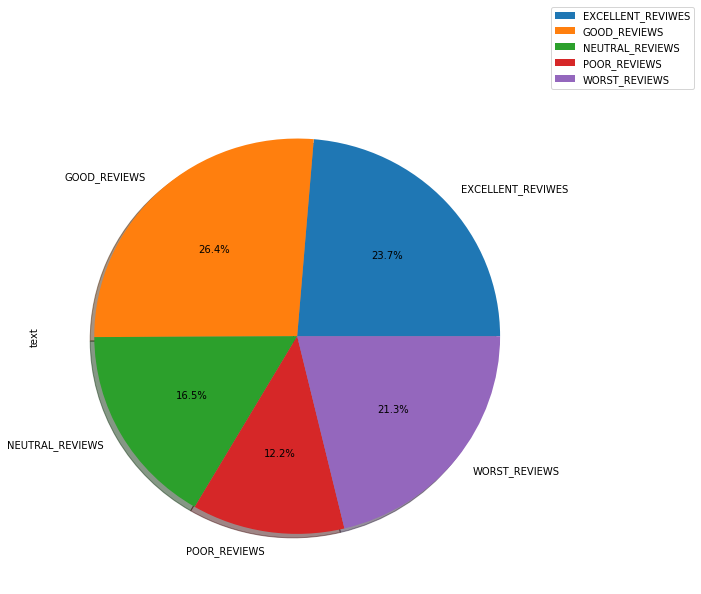

In [29]:
plt.subplot(222)
scraped_sentiment.plot(kind='pie',figsize=(20, 20),autopct='%1.1f%%',shadow=True)
plt.legend(bbox_to_anchor=(1, 1), loc=3, borderaxespad=0.)
plt.title('', bbox={'facecolor':'0.8', 'pad':0})
plt.show()

In [30]:
mnb_cfm = confusion_matrix(review_scraped_data['star'], tweets['vader_label'])
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')

Confusion matrix:
[[109  34  42  82 605]
 [ 53  13  20  53 360]
 [ 73  31  35  44 494]
 [101  38  50 110 783]
 [101  42  54  72 703]]



In [32]:
t = metrics.classification_report(review_scraped_data['star'], tweets['vader_label'])
print(t)

             precision    recall  f1-score   support

          1       0.25      0.12      0.17       872
          2       0.08      0.03      0.04       499
          3       0.17      0.05      0.08       677
          4       0.30      0.10      0.15      1082
          5       0.24      0.72      0.36       972

avg / total       0.23      0.24      0.18      4102



In [33]:
'''  Classifer comparison  naive bayes and SVM '''

'  Classifer comparison  naive bayes and SVM '

In [34]:
''' NAIVE BAYES '''

' NAIVE BAYES '

In [35]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(1, 2),sublinear_tf=True,
                                    token_pattern=r'\w{1,}', max_features=20000, stop_words='english')),
                      ('bayes', OneVsRestClassifier(MultinomialNB()))])

NaiveBayes_model = pipeline.fit(train['text'],train['star'])
pre = NaiveBayes_model.predict(test['text'])

In [36]:
t = metrics.classification_report(test['star'],pre)
print(t)

             precision    recall  f1-score   support

          1       0.77      0.97      0.86       595
          2       1.00      0.56      0.72       347
          3       0.95      0.73      0.82       451
          4       0.81      0.89      0.85       759
          5       0.86      0.88      0.87       678

avg / total       0.86      0.84      0.84      2830



Confusion matrix:
[[109  34  42  82 605]
 [ 53  13  20  53 360]
 [ 73  31  35  44 494]
 [101  38  50 110 783]
 [101  42  54  72 703]]



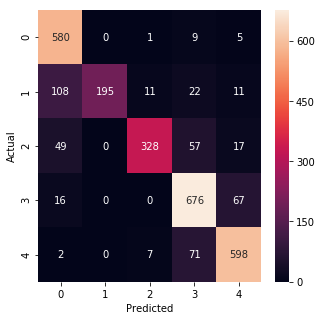

In [37]:
conf_mat = confusion_matrix(test['star'],pre)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


             precision    recall  f1-score   support

          1       0.77      0.97      0.86       595
          2       1.00      0.56      0.72       347
          3       0.95      0.73      0.82       451
          4       0.81      0.89      0.85       759
          5       0.86      0.88      0.87       678

avg / total       0.86      0.84      0.84      2830

Confusion matrix:
[[109  34  42  82 605]
 [ 53  13  20  53 360]
 [ 73  31  35  44 494]
 [101  38  50 110 783]
 [101  42  54  72 703]]



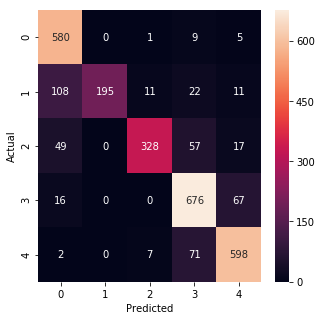

In [38]:
''' LINER SVC '''

svc_pipeline = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(1, 2),sublinear_tf=True,
                                    token_pattern=r'\w{1,}', max_features=20000, stop_words='english')),
                      ('bayes', OneVsRestClassifier(LinearSVC(), n_jobs=1))])

SVC_model = pipeline.fit(train['text'],train['star'])
pre = SVC_model.predict(test['text'])

t = metrics.classification_report(test['star'],pre)
print(t)

conf_mat = confusion_matrix(test['star'],pre)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [39]:
''' FINDING ACCURACY FOR EACH LABEL '''

' FINDING ACCURACY FOR EACH LABEL '

In [40]:
class_names

['star_1', 'star_2', 'star_3', 'star_4', 'star_5']

In [41]:
for i, class_name in enumerate(class_names):
    train_target = train_transform_dummies[class_name]
    pipeline.fit(train_transform_dummies['text'].values, train_target)
    cv_score = np.mean(cross_val_score(estimator = pipeline, X = train_transform_dummies['text'].values, 
                                      y = train_target, cv = 5, scoring = 'accuracy'))
    print('CV score for class {} is {}'.format(class_name, cv_score))


CV score for class star_1 is 0.8647799907364522
CV score for class star_2 is 0.9033132623127992
CV score for class star_3 is 0.8977977362204724
CV score for class star_4 is 0.9056377049590495
CV score for class star_5 is 0.8844303314678085


In [42]:
''' Analysing Twitter '''

' Analysing Twitter '

In [48]:
reviewData = []   
file_path = 'tweetlabled.csv'
twitter_data = pd.read_csv(file_path)


In [49]:
twitter_data = twitter_data.sample(frac = 1)

In [50]:
train = twitter_data[0:800]
test = twitter_data[800:]

,text,star
1053,Great little placeWe just had lunch today and ...,4
110,never experienced such bad servicereally reall...,1
226,Nice food but too expensiveI visited with a fr...,2
510,"Attentive service, lovely, filling food.My fri...",4
1133,Disgusting hygeineHi Bill! I'm very sorry abou...,1
2113,Nice dinnersI really enjoyed my meal. Chef wad...,5
36,"Don't come to this place. Bad food, bad servic...",1
283,Not a great experienceIm not sure how this pla...,2
2158,Disaster turned into triumph by great staffI w...,4
1715,Can you please open in Australia?I know for mo...,5


             precision    recall  f1-score   support

          1       0.66      0.83      0.74       271
          2       0.98      0.24      0.39       181
          3       0.87      0.27      0.41       264
          4       0.55      0.72      0.62       358
          5       0.58      0.82      0.68       328

avg / total       0.69      0.62      0.59      1402

Confusion matrix:
[[109  34  42  82 605]
 [ 53  13  20  53 360]
 [ 73  31  35  44 494]
 [101  38  50 110 783]
 [101  42  54  72 703]]



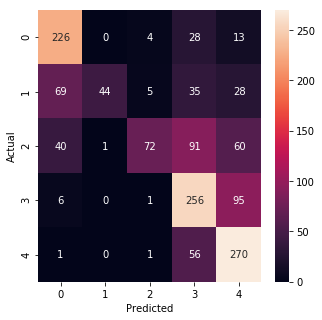

In [52]:
''' LINER SVC '''

svc_pipeline = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(1, 2),sublinear_tf=True,
                                    token_pattern=r'\w{1,}', max_features=20000, stop_words='english')),
                      ('bayes', OneVsRestClassifier(LinearSVC(), n_jobs=1))])

SVC_model = pipeline.fit(train['text'],train['star'])
pre = SVC_model.predict(test['text'])

t = metrics.classification_report(test['star'],pre)
print(t)

conf_mat = confusion_matrix(test['star'],pre)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()